# Approximate Bayesian Computation - Sequential Monte Carlo
Jakub Gwóźdź i Julia Żur
## ABC - SMC

### ABC - Approximate Bayesian Computation

<img src='tutorial/what-is-abc.png'>

~ Sunnåker

#### Twierdzenie Bayesa
$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$
#### Motywacja
Założenia:  
&nbsp;&nbsp;&nbsp;&nbsp; A ->  $\theta$ (parametr modelu)   
&nbsp;&nbsp;&nbsp;&nbsp; B -> D (dane)
<br><br>
$P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}$
    <br><br>
$P(\theta|D)$ - posterior <br>
$P(D|\theta)$ - likelihood <br>
$P(\theta)$ - prior ~ co uważamy o $\theta$ zanim mamy D, rozkład <br>
$P(D)$ - evidence ~ czynnik normalizujący, można go pominąć, gdy szukamy relacji <br>
<br>
$P(D|\theta)$ - trudne, czasochłonne, czasami niemożliwe do obliczenia dokładnie
<br>
Stąd ABC nazywane jest też likelihood free inference methods, bo nie ma potrzeby dokładnie obliczać czynnika prawdopodobieństwa.
#### Kiedy tak się dzieje?
Mamy dane eksperymentalne, ale nie znamy wszystkich parametrów wpływających na wynik, bo np. są one niemożliwe do zaobserwowania i/lub zupełnie losowe. <br>
Przykład: systemy biologiczne np. rozrost komórek rakowych, nie jesteśmy w stanie dokładnie określić, jak szybko komórki będą się rozrastać, bo nie znamy dokładnie wszystkich czynników na to wpływających.

#### Jak działa ABC?
<img src='tutorial/ABC-how-it-works.png'>

### ABC-SMC -> Approximate Bayesian Computation - Sequential Monte Carlo
> Sequential monte carlo ABC to metoda, która iteracyjnie modyfikuje $P(\theta)$
 (prior) w $P(\theta|D)$ (posterior) poprzez propagację próbek parametru $\theta$ przez szereg proponowanych dystrybucji $\phi(\theta^{(i)})$ (np. Gaussa) stosując wagi do parametru $\theta^{(i)}$ w taki sposób, że:
 <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\omega(i) ∝ \frac{P(\theta^{(i)})}{\phi(\theta^{(i)})} $
 <br>Jeśli przyjmiemy, że $\beta$ to parametr kontrolujący:
 <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P(\theta|D)_{\beta} ∝ P(D|\theta)^{\beta}P(\theta)$ 
 <br> Zauważmy, że jeśli $\beta = 0$ to $P(\theta|D) ∝ P(\theta)$, czyli startujemy od dystrybucji prior i w każdym kroku wprowadzamy próbki z $P(D|\theta)$.<br>
 Wynikiem jest zbiór próbek z dystrybucji tzw. posterior.
 
 SMC pozwala na próbkowanie funkcji posiadających wiele szczytów.
 
 <img src='tutorial/smc.png'>

### Estymacja parametrów
 <img src='tutorial/abc_smc.png'>

### Wybór optymalnego modelu

<img src='tutorial/abc_smc_model.png'> 

### ZADANIE 1

Algorytm ABC-SMC:

   0. Stwórz funkcję dystansu odpowiednią dla zadanego modelu.
   1. Pobierz próbki z rozkładu parametru $\alpha$ (prior distribution) wykorzystując metodę SMC.
   2. Dla każdej próbki z punktu 1 stwórz symulację wykorzystując model, która zwraca zbiór danych o takim samym rozmiarze jak dane z obserwacji.
   3. Porównaj dane wynikowe z punktu 2 z danymi z obserwacji wykorzystując funkcję dystansu z punktu 0.
   4. Znajdź te dystrybucje, dla których funkcja dystansu zwraca wartość  $\leq \epsilon$.
   5. Stwórz nową, poprawioną dystrybucję parametru $\alpha$.

#### Model 
Przykładowym modelem będą dane, których rozkład jest zgodny z rozkładem Gaussa. 

Posiada on dwa parametry $\mu$ - wartość oczekiwana oraz $\sigma$ - odchylenie standardowe: $N(\mu,\sigma^2)$ . <br> 
W takim wypadku można wykorzystać odległość Euklidesa jako funkcję dystansu.

In [1]:
import pylab as plt
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
from collections import Counter
%matplotlib inline
plt.style.use('ggplot')

Implementacja modelu. Do wykonania:
  * Funkcja dystansu
  * Obliczanie summmary statistics (średniej w przypadku modelu Gaussa)

In [2]:
class GaussianModel:

    
    # Generowanie danych, loc - wartość oczekiwana, scale - odchylenie standardowe
    def generate_data(self, theta, sigma=1):
        return stats.norm.rvs(loc=theta, scale=sigma, size=self.data_size)
    
    # zaimplementuj funckję dystansu 
    def distance_function(self, data, synthetic_data):
        
        return np.abs(data - synthetic_data) # ?
        # raise Exception('Not implemented')
    
    # Zwraca parametry modelu do estymacji dla zadanych danych
    def summary_stats(self, data):
        
        # obliczyć wartość oczekiwaną (średnią) danych
        mu = np.mean(data) # ?
        sigma = np.std(data)
        
        return (mu)
    
    # Funkcja zwracająca rozkład prior przy pierwszym kroku
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    # SETTERY
    
    def set_data(self, data):
        self.data = data
        self.data_sum_stats = self.summary_stats(self.data)
        self.data_size = len(data)
        
    def set_prior(self, prior):
        self.prior = prior

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

Algorytm ABC. Jest on wywoływany w funckji ABC_SMC. Do zaimplementowania są:
  * pierwszy krok ABC
  * symulacja
  * obliczenie summary statistic
  * obliczenie dystansu

In [3]:
def ABC(model, data, epsilon=1, min_samples=10, smc_mode=False,
        weights='None', theta_prev='None', tau_squared='None'):

    posterior, distances = [], []
    trial_count, accepted_count = 0, 0
    
    # pobranie summary statistic z modelu
    data_summary_stats = model.summary_stats(data)
        
    # wykonaj próbkowanie metodą SMC do uzyskania zadanej liczby próbek
    while accepted_count < min_samples:
        
        trial_count += 1
    
        if smc_mode:
            
            # Obcinamy próbki do tych, które mieszczą się w rozkładzie
            theta_star = theta_prev[:, np.random.choice(
                        range(0, theta_prev.shape[1]),replace=True, p=[weight/sum(weights) for weight in weights]
            )]
            
            # Tworzymy rozkład normalny o zadanej średniej i kowariancji oraz pobieramy losowe próbki
            theta = stats.multivariate_normal.rvs(theta_star, tau_squared)
            if np.isscalar(theta) == True:
                theta = [theta]
    
        # pierwszy krok
        else:
            theta = model.draw_theta() # ?
        
        # stwórz symulację, odtwórz dane z użyciem funkcji generate_data z odpowiednim parametrem dla każdej próbki
        
        simulation_data = model.generate_data(theta) # model.generate_data(theta)

        # pobierz summary statistic dla nowo utworzonych danych
        
        simulation_summary_stats = model.summary_stats(simulation_data) # ?
        
        # oblicz dystans pomiędzy summary statistic danych oryginalnych oraz z symulacji, 
        # wykorzystaj funkcję zdefiniowaną w modelu
        
        distance = model.distance_function(data_summary_stats, simulation_summary_stats) # ?

        # jeżeli próbka jest zaakceptowana, zapisujemy ją
        
        if distance < epsilon:
            accepted_count += 1
            posterior.append(theta)
            distances.append(distance)

    posterior = np.asarray(posterior).T

    if len(posterior.shape) > 1:
        n = posterior.shape[1]
    else:
        n = posterior.shape[0]

    weights = np.ones(n)
    tau_squared = np.zeros((posterior.shape[0], posterior.shape[0]))
    
    return (posterior, distances,
            accepted_count, trial_count,
            epsilon, weights, tau_squared)

Funckja obliczająca parametry SMC w kolejnych krokach i przekazująca sterowanie do algorytmu ABC.
Do zaimplementowania są:
  * wywołanie funkcji ABC w pierwszym kroku
  * wywołanie funkcji ABC w kolejnych krokach

In [4]:
def ABC_SMC(model, data, epsilon0=1, min_samples=10, steps=10):

    output_record = np.empty(steps, dtype=[('theta accepted', object),
                                           ('D accepted', object),
                                           ('n accepted', float),
                                           ('n total', float),
                                           ('epsilon', float),
                                           ('weights', object),
                                           ('tau_squared', object)
                                           ])
    
    steps = range(steps)
    epsilon = epsilon0
    
    for step in steps:
        
        print('Starting step ' + str(step))
        
        # jeżeli pierwszy krok to wykonujemy krok ABC bez SMC 
        if step == 0:

            # wywołaj funkcję ABC z parametrami potrzebnymi w pierwszym kroku, na razie bez trybu SMC
            output_record[step] = ABC(model, data, epsilon=epsilon,
                                            min_samples=min_samples, smc_mode=False) # ?
            
            # zapisujemy do historii parametry dla każdego kroku
            theta = output_record[step]['theta accepted']
            
            # obliczamy kowariancję wartości oczekiwanej
            tau_squared = 2 * np.cov(theta)
            
            # inicjujemy wagi
            weights = np.ones(theta.shape[1]) * 1.0/theta.shape[1]
            
            # Obliczany jest percentyl 75, który zostaje nowym epsilonem w kolejnym kroku
            epsilon = stats.scoreatpercentile(output_record[step]['D accepted'],
                                              per=75)

            output_record[step]['weights'] = weights
            output_record[step]['tau_squared'] = tau_squared
            
        # wykonujemy kolejny krok SMC
        else:
            
            # obliczone w każdym kroku theta i wagi przekazujemy jako parametry do ABC
            theta_prev = theta
            weights_prev = weights

            # wywołaj funkcję ABC ze wszystkimi parametrami, pamiętaj o odpowiednim trybie SMC
            output_record[step] = ABC(model, data, epsilon=epsilon,
                                            min_samples=min_samples, smc_mode=True,
                                            weights=weights, theta_prev=theta_prev,
                                            tau_squared=tau_squared) # ?
            
            # zapisujemy parametry do historii
            theta = output_record[step]['theta accepted']
            epsilon = stats.scoreatpercentile(output_record[step]['D accepted'], per=75)
            
            output_record[step]['tau_squared'] = tau_squared
            output_record[step]['weights'] = weights
            
    return output_record

### ZADANIE 2

Wykonać estymację parametrów dla zadanego modelu i narysować wykresy. <br> Porównać wyniki dla algorytmu ABC-SMC z samym ABC.

Funkcja last_step_ABC_SMC działa dla obu wersji algorytmu (ABC i ABC-SMC), dla samego ABC nie podajemy parametru steps.

In [5]:
def all_steps_ABC_SMC(smc_posterior):
    eps = []
    for i in smc_posterior:
        eps.append(i['epsilon'])
        mu = i[0][0]

        mukde = stats.gaussian_kde(mu)

        plt.figure(figsize=(15,3))
        plt.subplots_adjust(wspace=0.4)
        plt.subplot(121)
        x = np.linspace(-2,2,1000)
        y = [mukde(val) for val in x]
        plt.suptitle(r'$\epsilon$ = {:.3f}, $\mu$ = {:.3f}'.format(i['epsilon'], x[y.index(max(y))]))
        plt.plot(x, y)
        plt.axvline(theta0, ls='--')
        plt.ylim(0,5)
        plt.xlim(-2,2)
        plt.xlabel(r"$\mu$", fontsize=30)

        plt.subplot(122)

        plt.plot(eps,'-o')
        plt.xlabel('Step', fontsize=24)
        plt.ylabel(r'$\epsilon$', fontsize=30)
        plt.xlim(-1,15)
        plt.ylim(0,1)

In [6]:
def last_step_ABC_SMC(posterior, steps=1):    
    mu = posterior[steps-1][0]

    mukde = stats.gaussian_kde(mu)

    plt.figure(figsize=(15,6))
    plt.subplots_adjust(wspace=0.2)
    plt.subplot(111)
    x = np.linspace(-2,2,1000)
    plt.plot(x, mukde(x))
    plt.axvline(theta0, ls="--")
    plt.xlabel(r"$\mu$", fontsize=30)
    plt.ylim(0,5)
    plt.xlim(-2,2)

In [47]:
def ABC_SMC_over_data(posterior, data, step=0):
    mu = posterior[step][0]
    data_mu = np.mean(data)
    sigma = np.std(data)
    
    mukde = stats.gaussian_kde(mu)

    c = Counter(data)
    
    plt.figure(figsize=(15,6))
    x = np.linspace(data_mu - 3*sigma, data_mu + 3*sigma, len(list(c.values())))
    x_sim = np.linspace(-1,2,1000)
    plt.plot(x_sim, mukde(x_sim), 'b')
    
    data_y = np.array([c[d] for d in sorted(list(c.keys()))])

    plt.bar(x, data_y/np.max(data_y))
    plt.show()

Dane pochodzą z aplikacji Spotify i dotyczą ocen piosenek.

In [8]:
data_file = './genres_v2.csv'
danceability_df = pd.read_csv(data_file)
danceability_df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [9]:
danceability_df['danceability'].describe()

count    42305.000000
mean         0.639364
std          0.156617
min          0.065100
25%          0.524000
50%          0.646000
75%          0.766000
max          0.988000
Name: danceability, dtype: float64

In [10]:
danceability_df['bin'] = pd.cut(danceability_df['danceability'], bins=100).sort_values()

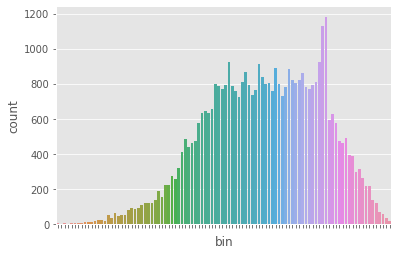

In [11]:
bar_danceability = sns.countplot(x=danceability_df['bin'])
bar_danceability.set(xticklabels=[])
plt.show()

In [12]:
theta0 = 0
sigma0 = 1
epsilon0 = 0.5
min_samples = 10
steps = 15

model = GaussianModel()

# Wybieramy dane
data = list(danceability_df['danceability'])

# Musimy stworzyć pierwszy rozkład prior ze startowymi wartościami parametrów
model.set_prior([stats.norm(loc=theta0,scale=sigma0)]) # ?

model.set_data(data)

-0.7506147172558728


Wykonujemy estymację posterior przy użyciu algorytmu ABC.

In [13]:
posterior = ABC(model, data, epsilon0, min_samples) # ?

Wykonujemy estymację posterior przy użyciu algorytmu ABC_SMC.

In [14]:
smc_posterior = ABC_SMC(model, data, epsilon0, min_samples, steps) # ?

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14


Narysuj wykresy wykorzystując funkcje zdefiniowane wyżej (all_steps_ABC_SMC, last_step_ABC_SMC). <br>
Dla ABC rysujemy tylko last step.

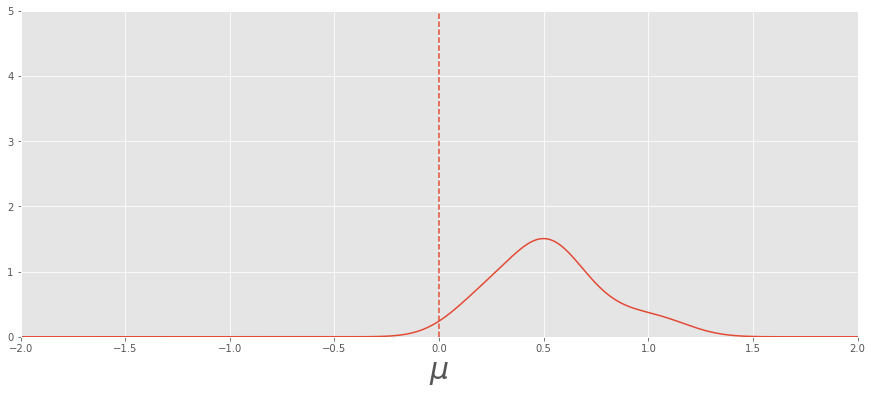

In [15]:
last_step_ABC_SMC(posterior) # ?

Dla ABC_SMC można narysować oba wykresy. Należy tylko pamiętać o parametrze steps.

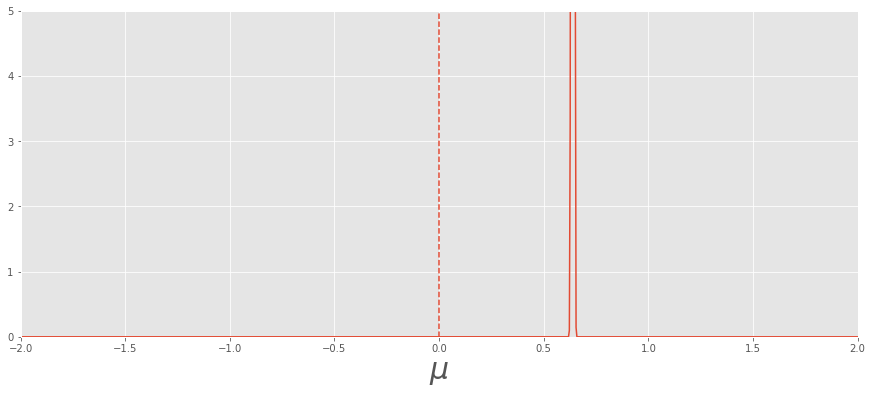

In [16]:
last_step_ABC_SMC(smc_posterior, steps)

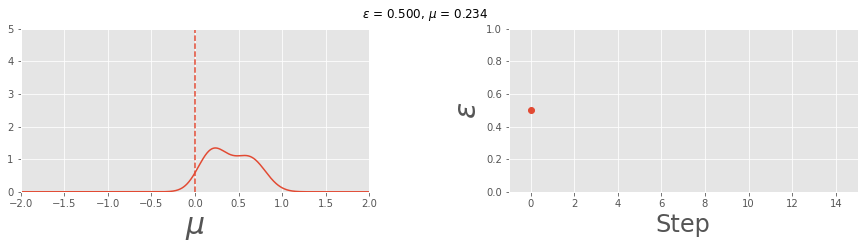

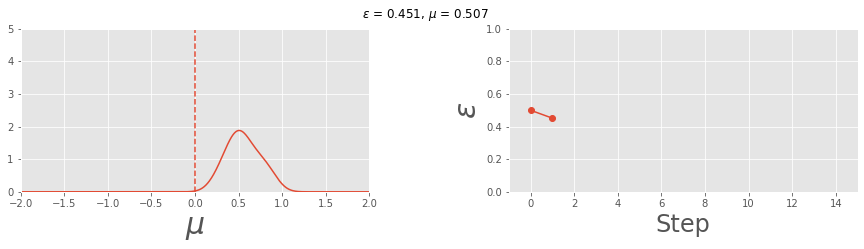

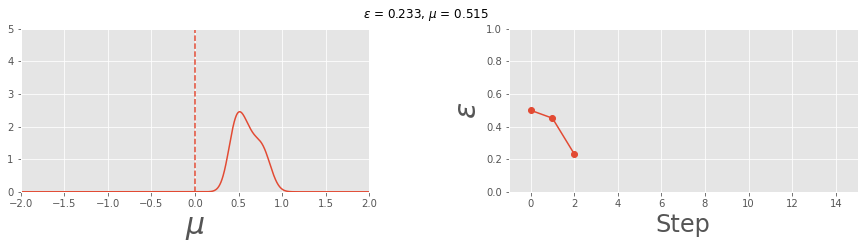

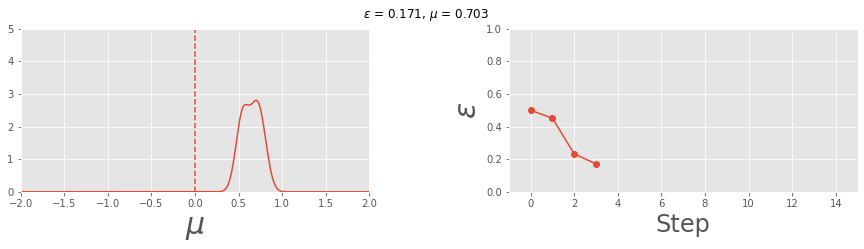

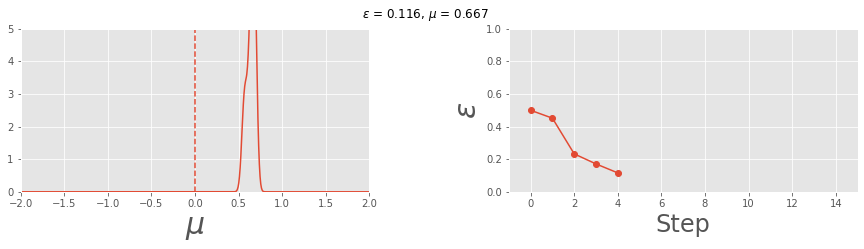

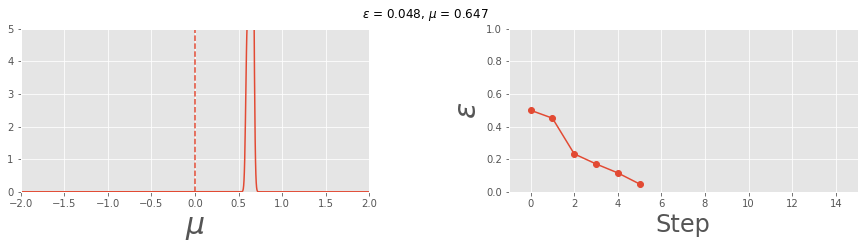

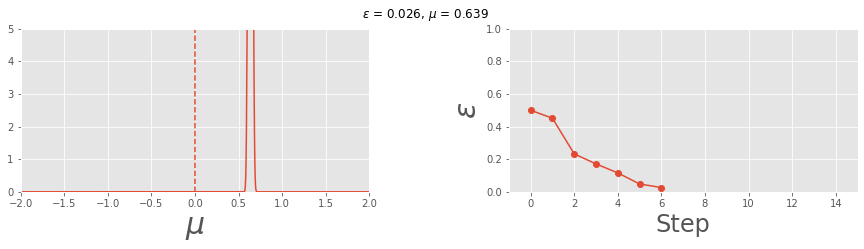

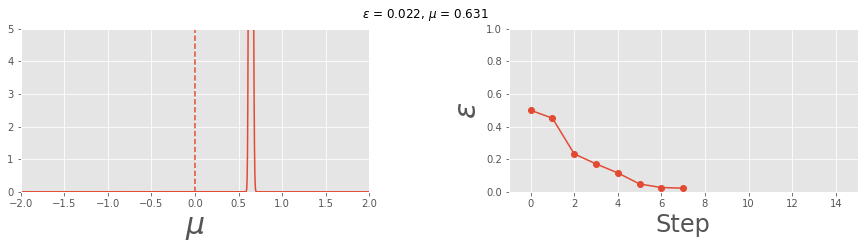

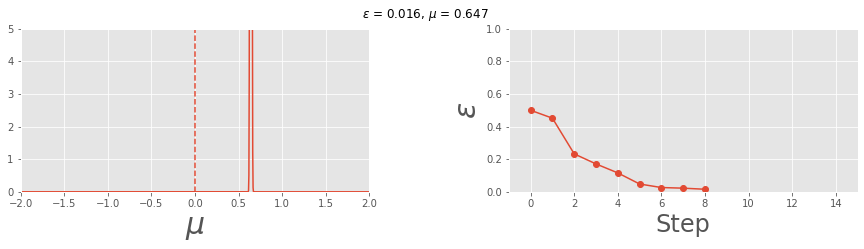

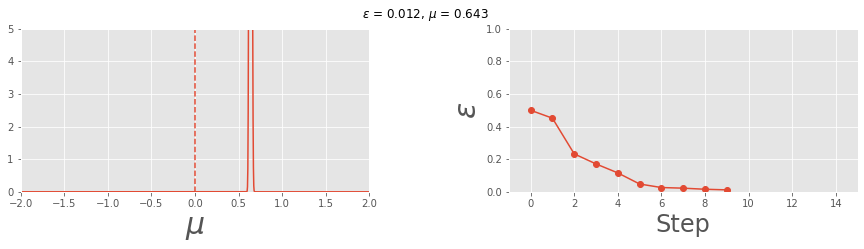

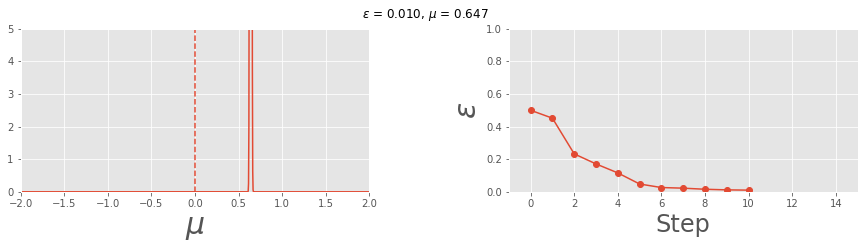

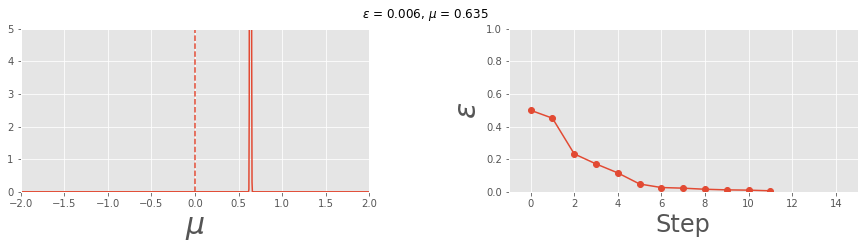

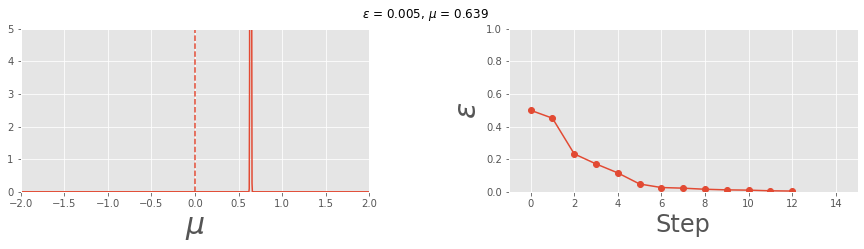

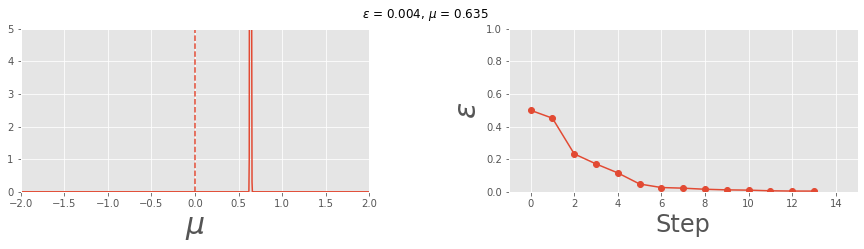

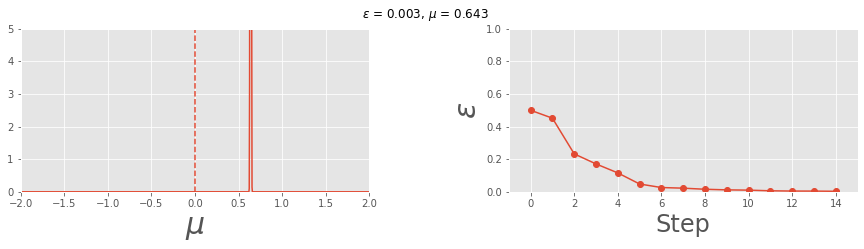

In [17]:
all_steps_ABC_SMC(smc_posterior)

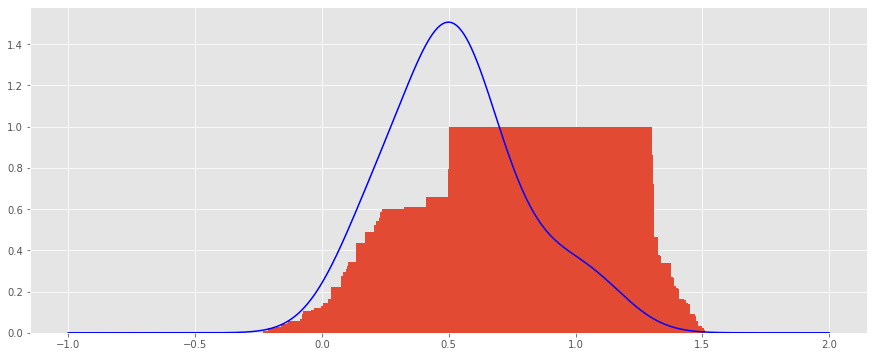

In [48]:
ABC_SMC_over_data(posterior, data)

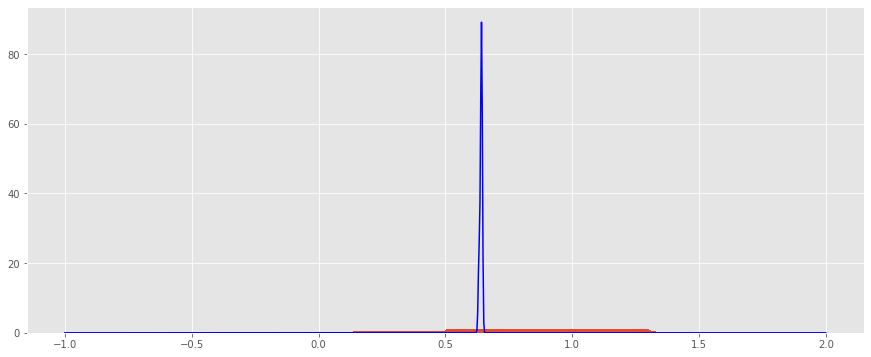

In [49]:
ABC_SMC_over_data(smc_posterior, data, step=14)

### Dla bardziej zainteresowanych, Źródła
https://www.nature.com/articles/npre.2011.5964.1 <br>
https://docs.pymc.io/notebooks/SMC-ABC_Lotka-Volterra_example.html <br>
https://en.wikipedia.org/wiki/Approximate_Bayesian_computation <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3547661/ <br>
https://github.com/rcmorehead/simpleabc/blob/master/simple_abc.py <br>
https://clincancerres.aacrjournals.org/content/18/18/5071